In [140]:
import numpy as np
import mdp
from CT_ucrl import ct_ucrl, extended_value_iteration
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test of CT_MDP

In [141]:
eps = 0.2
alpha = 0.1
p = [
        [[1, 0], [1 - eps, eps]],
        [[0, 1], [eps, 1 - eps]],
    ]
r = [
        [1 - alpha, 1 - alpha],
        [1, 1],
    ]
holding_lambda = [[3, 2], [1, 4]]
ct_mdp = mdp.CTMDP(2, 2, p, r, holding_lambda)
holding_time_record = {0: {0: [], 1:[]}, 1: {0: [], 1:[]}}
transit_record = {0: {0: np.array([0, 0]), 1:np.array([0, 0])}, 
                  1: {0: np.array([0, 0]), 1:np.array([0, 0])}}

In [142]:
print(ct_mdp.reset(0))
for i in range(5000):
    ac = np.random.randint(2)
    state = ct_mdp.state
    next_state, reward, holding_time = ct_mdp.step(ac)
    holding_time_record[state][ac].append(holding_time)
    transit_record[state][ac][next_state] += 1

0


In [143]:
for state in [0, 1]:
    for action in [0, 1]:
        print(state, action, 1/np.mean(holding_time_record[state][action]))
        print(transit_record[state][action]/np.sum(transit_record[state][action]))

0 0 3.1966328109625244
[1. 0.]
0 1 2.070776427313372
[0.80988593 0.19011407]
1 0 1.0197830113312452
[0. 1.]
1 1 3.8485909482431144
[0.20798669 0.79201331]


# Test of CT_UCRL

In [198]:
eps = 0.1
alpha = 0.1
n_states = n_actions = 2
p = np.array([[[0, 1],[0, 1]],
     [[1, 0],[1, 0]]])
r = np.array([[5, 8], [-4, -12]])
r = np.asarray(r)
holding_lambda = np.array([[3, 5], [2, 7]])
num_dec_epoch = 500000

In [200]:
ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)

transitions = ct_ucrl(ct_mdp, np.max(holding_lambda), np.min(holding_lambda), 
                      r, 0.05, 0)
opt_tr = []
for _ in range(num_dec_epoch):
    (t, st, ac, next_st, reward) = transitions.__next__()
    opt_tr.append((t, ct_mdp.timer, st, ac, next_st, reward))

In [201]:
np_tr = np.array(opt_tr)
opt_cumsum_r = np.cumsum(np_tr[:, -1], 0)
opt_rho = opt_cumsum_r[-1] / ct_mdp.timer
opt_rho

5.706776155563075

In [202]:
state_val, best_ac, est_mdp = extended_value_iteration(2, 2, np.array(r), np.array(p), 
                                                   np.zeros(np.shape(p)[:2]), 
                                                   1 / np.array(holding_lambda), 
                                                   np.zeros(np.shape(holding_lambda)), 
                                                   2, 7, 0.01)

In [203]:
rho_star = ((p[0][1] * state_val).sum() - state_val[0] + r[0, 1]) * holding_lambda[0, 1]

# Sub-optimal Policy

In [204]:
ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)
st = ct_mdp.reset(0)
sub_policy = np.array([0, 0])
sub_tr = []
for n in range(num_dec_epoch):
    next_st, reward, holding_time = ct_mdp.step(ac)
    # print('step', t, st, ac, next_st, reward)
    # Update statistics

    st = next_st
    ac = sub_policy[st]
    sub_tr.append((n, ct_mdp.timer, st, ac, next_st, reward))

In [205]:
np_sub_tr = np.array(sub_tr)
sub_rho = np_sub_tr[:, -1].sum() / ct_mdp.timer
sub_rho
sub_gap = rho_star - sub_rho
sub_gap

4.507571395241639

In [206]:
bound_const = 34**2 * holding_lambda.max() * 4 * 2 
print(bound_const)
bound_const += 2 * 73**2 * (holding_lambda.max() / holding_lambda.min())**2 * 2 * 2
bound_const += 24 * 2 * 2 / (holding_lambda.min()**2) 
bound_const *= 3

64736


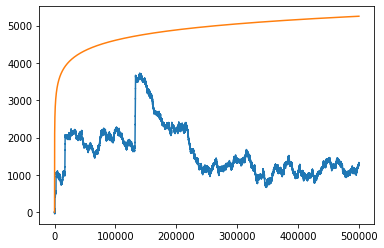

In [207]:
plt.plot(np_tr[:, 1] * rho_star - opt_cumsum_r)
plt.plot(400 * np.log(np_tr[:, 0]))

In [ ]:
bound_const 

1761006.0

In [ ]:
cumsum_mdp[:, 5]

array([8.00000e+00, 4.00000e+00, 1.20000e+01, ..., 9.98460e+05,
       9.98468e+05, 9.98464e+05])